In [33]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

In [30]:
def data_loaders(root, batch_size, valid_size=0.1, option='cifar10', cuda=False, random_seed=1113):
    # Prepare datasets
    kwargs = {'num_workers': 8, 'pin_memory': True} if torch.cuda.is_available() and cuda else {}

    if option == 'cifar10':
        # Load CIFAR10 dataset
        transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                                              Cutout(n_holes=1, length=16)
                                              ])

        transform_test = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                             ])

        training_set = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
        validation_set = datasets.CIFAR10(root=root, train=True, transform=transform_test)
        test_set = datasets.CIFAR10(root=root, train=False, transform=transform_test)

        # classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    elif option == 'mnist':
        # Load MNIST
        transform_train = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.1307,), (0.3081,))
                                              ])

        transform_test = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.1307,), (0.3081,))
                                             ])

        training_set = datasets.MNIST(root=root, train=True, download=True, transform=transform_train)
        validation_set = datasets.MNIST(root=root, train=True, transform=transform_test)
        test_set = datasets.MNIST(root=root, train=False, transform=transform_test)
        # classes = tuple(range(10))

    else:
        raise ValueError("Data option not supported.")

    valid_size = valid_size
    num_train = len(training_set)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,
                                               sampler=train_sampler, **kwargs)
    valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,
                                               sampler=valid_sampler, **kwargs)

    full_train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)

    return train_loader, valid_loader, full_train_loader, test_loader, valid_size

In [31]:
data_path = "data/"


train_loader, valid_loader, full_train_loader, test_loader, valid_size \
                = data_loaders(root=data_path, batch_size=128, valid_size=0.3,
                                   option='mnist', cuda=True)

In [32]:
print(next(enumerate(train_loader))[1][0].shape)

torch.Size([128, 1, 28, 28])


In [61]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 784)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc4(x)
        x = F.dropout(x, 0.3)
        
        return x
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = F.dropout(x, 0.3)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.2)
        x = F.dropout(x, 0.3)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.2)
        x = F.dropout(x, 0.3)
        x = self.fc4(x)
        x = F.sigmoid(x)
        
        return x

In [120]:
def train(generator, discriminator, data_loader, epochs=100, log_interval=10):
    if torch.cuda.is_available():
        generator = generator.cuda()
        discriminator = discriminator.cuda()
        
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
        
    for epoch in range(1, epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader, 1):
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            batch_size = data.shape[0]
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            z_input = torch.randn(batch_size, 100)
            
            if torch.cuda.is_available():
                z_input = z_input.cuda()
                
            g_output = generator(z_input)
        
            fake_labels = torch.ones(batch_size)
            real_labels = torch.zeros(batch_size)    
            
            if torch.cuda.is_available():
                fake_labels = fake_labels.cuda()
                real_labels = real_labels.cuda()

            d_output_fake = discriminator(g_output)
            d_output_real = discriminator(data.view(-1, data.size(1) * data.size(2) * data.size(3)))
            
            fake_loss =  F.binary_cross_entropy(d_output_fake, fake_labels)
            real_loss = F.binary_cross_entropy(d_output_real, real_labels)
            d_loss = fake_loss + real_loss
            g_loss = -fake_loss

            d_loss.backward(retain_graph=True)
            g_loss.backward()

            g_optimizer.step()
            d_optimizer.step()
                    
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [Iter: {}]\t Gloss: {:.6f} Dloss: {:.6f}'.format(
                      epoch, batch_idx, g_loss.data.item(), d_loss.data.item()))
                    
                
        if not epoch % log_interval:
            images_torch = g_output.view(-1, 1, 28, 28)
            images = images_torch.cpu().detach().numpy()
            img = images[0]
            print(img.shape)
            img = np.rollaxis(img, 0, 3).squeeze(2)                       
            print(img.shape)
            plt.figure(figsize=(4, 4))
            plt.imshow(img, cmap='gray')
            plt.show()
        

In [121]:
g_model = Generator()
d_model = Discriminator()

Train Epoch: 1 [Iter: 100]	 Gloss: -0.798105 Dloss: 0.798106
Train Epoch: 1 [Iter: 200]	 Gloss: -0.794137 Dloss: 0.794137
Train Epoch: 1 [Iter: 300]	 Gloss: -0.796919 Dloss: 0.796919
Train Epoch: 2 [Iter: 100]	 Gloss: -0.797748 Dloss: 0.797748
Train Epoch: 2 [Iter: 200]	 Gloss: -0.795564 Dloss: 0.795564
Train Epoch: 2 [Iter: 300]	 Gloss: -0.796523 Dloss: 0.796523
Train Epoch: 3 [Iter: 100]	 Gloss: -0.797858 Dloss: 0.797858
Train Epoch: 3 [Iter: 200]	 Gloss: -0.798877 Dloss: 0.798877
Train Epoch: 3 [Iter: 300]	 Gloss: -0.799011 Dloss: 0.799012
Train Epoch: 4 [Iter: 100]	 Gloss: -0.796869 Dloss: 0.796869
Train Epoch: 4 [Iter: 200]	 Gloss: -0.793236 Dloss: 0.793239
Train Epoch: 4 [Iter: 300]	 Gloss: -0.792961 Dloss: 0.792961
Train Epoch: 5 [Iter: 100]	 Gloss: -0.795920 Dloss: 0.795920
Train Epoch: 5 [Iter: 200]	 Gloss: -0.796368 Dloss: 0.796368
Train Epoch: 5 [Iter: 300]	 Gloss: -0.800466 Dloss: 0.800466
Train Epoch: 6 [Iter: 100]	 Gloss: -0.800902 Dloss: 0.800902
Train Epoch: 6 [Iter: 20

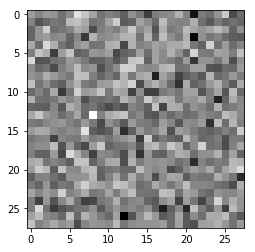

Train Epoch: 11 [Iter: 100]	 Gloss: -0.799301 Dloss: 0.799301
Train Epoch: 11 [Iter: 200]	 Gloss: -0.797972 Dloss: 0.797972
Train Epoch: 11 [Iter: 300]	 Gloss: -0.798024 Dloss: 0.798024
Train Epoch: 12 [Iter: 100]	 Gloss: -0.799584 Dloss: 0.799584
Train Epoch: 12 [Iter: 200]	 Gloss: -0.801483 Dloss: 0.801483
Train Epoch: 12 [Iter: 300]	 Gloss: -0.802419 Dloss: 0.802419
Train Epoch: 13 [Iter: 100]	 Gloss: -0.801071 Dloss: 0.801071
Train Epoch: 13 [Iter: 200]	 Gloss: -0.800321 Dloss: 0.800321
Train Epoch: 13 [Iter: 300]	 Gloss: -0.800655 Dloss: 0.800655
Train Epoch: 14 [Iter: 100]	 Gloss: -0.800699 Dloss: 0.800700
Train Epoch: 14 [Iter: 200]	 Gloss: -0.798715 Dloss: 0.798715
Train Epoch: 14 [Iter: 300]	 Gloss: -0.803685 Dloss: 0.803685
Train Epoch: 15 [Iter: 100]	 Gloss: -0.803289 Dloss: 0.803289
Train Epoch: 15 [Iter: 200]	 Gloss: -0.802437 Dloss: 0.802437
Train Epoch: 15 [Iter: 300]	 Gloss: -0.804362 Dloss: 0.804362
Train Epoch: 16 [Iter: 100]	 Gloss: -0.801857 Dloss: 0.801857
Train Ep

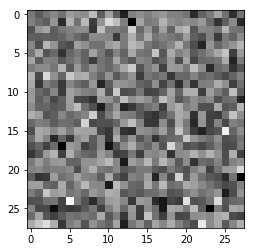

Train Epoch: 21 [Iter: 100]	 Gloss: -0.804799 Dloss: 0.804799
Train Epoch: 21 [Iter: 200]	 Gloss: -0.809595 Dloss: 0.809595
Train Epoch: 21 [Iter: 300]	 Gloss: -0.809058 Dloss: 0.809058
Train Epoch: 22 [Iter: 100]	 Gloss: -0.804868 Dloss: 0.804868
Train Epoch: 22 [Iter: 200]	 Gloss: -0.808689 Dloss: 0.808689
Train Epoch: 22 [Iter: 300]	 Gloss: -0.808844 Dloss: 0.808844
Train Epoch: 23 [Iter: 100]	 Gloss: -0.811004 Dloss: 0.811004
Train Epoch: 23 [Iter: 200]	 Gloss: -0.806059 Dloss: 0.806059
Train Epoch: 23 [Iter: 300]	 Gloss: -0.810034 Dloss: 0.810034
Train Epoch: 24 [Iter: 100]	 Gloss: -0.813570 Dloss: 0.813570
Train Epoch: 24 [Iter: 200]	 Gloss: -0.810231 Dloss: 0.810231
Train Epoch: 24 [Iter: 300]	 Gloss: -0.811055 Dloss: 0.811055
Train Epoch: 25 [Iter: 100]	 Gloss: -0.808054 Dloss: 0.808054
Train Epoch: 25 [Iter: 200]	 Gloss: -0.810484 Dloss: 0.810484
Train Epoch: 25 [Iter: 300]	 Gloss: -0.813156 Dloss: 0.813156
Train Epoch: 26 [Iter: 100]	 Gloss: -0.810322 Dloss: 0.810322
Train Ep

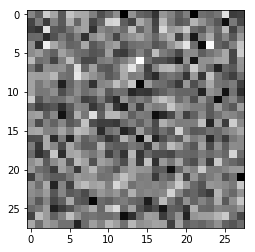

Train Epoch: 31 [Iter: 100]	 Gloss: -0.814755 Dloss: 0.814755
Train Epoch: 31 [Iter: 200]	 Gloss: -0.817333 Dloss: 0.817333
Train Epoch: 31 [Iter: 300]	 Gloss: -0.811074 Dloss: 0.811074
Train Epoch: 32 [Iter: 100]	 Gloss: -0.814249 Dloss: 0.814249
Train Epoch: 32 [Iter: 200]	 Gloss: -0.813442 Dloss: 0.813442
Train Epoch: 32 [Iter: 300]	 Gloss: -0.815108 Dloss: 0.815108
Train Epoch: 33 [Iter: 100]	 Gloss: -0.815248 Dloss: 0.815248
Train Epoch: 33 [Iter: 200]	 Gloss: -0.817077 Dloss: 0.817077
Train Epoch: 33 [Iter: 300]	 Gloss: -0.818850 Dloss: 0.818850
Train Epoch: 34 [Iter: 100]	 Gloss: -0.814209 Dloss: 0.814209
Train Epoch: 34 [Iter: 200]	 Gloss: -0.819804 Dloss: 0.819804
Train Epoch: 34 [Iter: 300]	 Gloss: -0.812564 Dloss: 0.812564
Train Epoch: 35 [Iter: 100]	 Gloss: -0.818038 Dloss: 0.818038
Train Epoch: 35 [Iter: 200]	 Gloss: -0.818019 Dloss: 0.818019
Train Epoch: 35 [Iter: 300]	 Gloss: -0.819610 Dloss: 0.819610
Train Epoch: 36 [Iter: 100]	 Gloss: -0.817576 Dloss: 0.817576
Train Ep

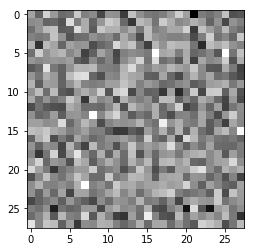

Train Epoch: 41 [Iter: 100]	 Gloss: -0.820318 Dloss: 0.820318
Train Epoch: 41 [Iter: 200]	 Gloss: -0.820522 Dloss: 0.820522
Train Epoch: 41 [Iter: 300]	 Gloss: -0.818575 Dloss: 0.818575
Train Epoch: 42 [Iter: 100]	 Gloss: -0.821552 Dloss: 0.821552
Train Epoch: 42 [Iter: 200]	 Gloss: -0.826535 Dloss: 0.826535
Train Epoch: 42 [Iter: 300]	 Gloss: -0.824083 Dloss: 0.824083
Train Epoch: 43 [Iter: 100]	 Gloss: -0.821959 Dloss: 0.821959
Train Epoch: 43 [Iter: 200]	 Gloss: -0.827088 Dloss: 0.827088
Train Epoch: 43 [Iter: 300]	 Gloss: -0.820433 Dloss: 0.820433
Train Epoch: 44 [Iter: 100]	 Gloss: -0.826689 Dloss: 0.826689
Train Epoch: 44 [Iter: 200]	 Gloss: -0.824718 Dloss: 0.824718
Train Epoch: 44 [Iter: 300]	 Gloss: -0.819443 Dloss: 0.819443
Train Epoch: 45 [Iter: 100]	 Gloss: -0.818988 Dloss: 0.818988
Train Epoch: 45 [Iter: 200]	 Gloss: -0.820641 Dloss: 0.820641
Train Epoch: 45 [Iter: 300]	 Gloss: -0.823323 Dloss: 0.823323
Train Epoch: 46 [Iter: 100]	 Gloss: -0.818880 Dloss: 0.818880
Train Ep

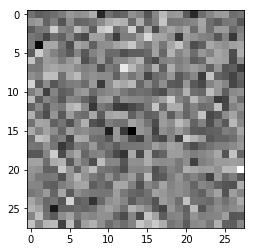

Train Epoch: 51 [Iter: 100]	 Gloss: -0.824707 Dloss: 0.824707
Train Epoch: 51 [Iter: 200]	 Gloss: -0.824042 Dloss: 0.824042
Train Epoch: 51 [Iter: 300]	 Gloss: -0.829504 Dloss: 0.829504
Train Epoch: 52 [Iter: 100]	 Gloss: -0.826219 Dloss: 0.826219
Train Epoch: 52 [Iter: 200]	 Gloss: -0.829811 Dloss: 0.829811
Train Epoch: 52 [Iter: 300]	 Gloss: -0.829583 Dloss: 0.829583
Train Epoch: 53 [Iter: 100]	 Gloss: -0.828307 Dloss: 0.828307
Train Epoch: 53 [Iter: 200]	 Gloss: -0.828778 Dloss: 0.828778
Train Epoch: 53 [Iter: 300]	 Gloss: -0.828694 Dloss: 0.828694
Train Epoch: 54 [Iter: 100]	 Gloss: -0.828707 Dloss: 0.828707
Train Epoch: 54 [Iter: 200]	 Gloss: -0.828967 Dloss: 0.828967
Train Epoch: 54 [Iter: 300]	 Gloss: -0.831503 Dloss: 0.831503
Train Epoch: 55 [Iter: 100]	 Gloss: -0.832237 Dloss: 0.832237
Train Epoch: 55 [Iter: 200]	 Gloss: -0.828640 Dloss: 0.828640
Train Epoch: 55 [Iter: 300]	 Gloss: -0.829325 Dloss: 0.829325
Train Epoch: 56 [Iter: 100]	 Gloss: -0.830074 Dloss: 0.830074
Train Ep

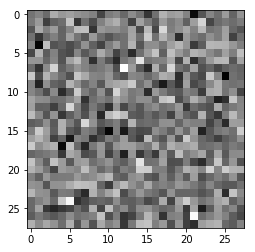

Train Epoch: 61 [Iter: 100]	 Gloss: -0.826995 Dloss: 0.826995
Train Epoch: 61 [Iter: 200]	 Gloss: -0.830772 Dloss: 0.830772
Train Epoch: 61 [Iter: 300]	 Gloss: -0.830729 Dloss: 0.830729
Train Epoch: 62 [Iter: 100]	 Gloss: -0.834545 Dloss: 0.834545
Train Epoch: 62 [Iter: 200]	 Gloss: -0.830070 Dloss: 0.830070
Train Epoch: 62 [Iter: 300]	 Gloss: -0.831915 Dloss: 0.831915
Train Epoch: 63 [Iter: 100]	 Gloss: -0.824455 Dloss: 0.824455
Train Epoch: 63 [Iter: 200]	 Gloss: -0.832025 Dloss: 0.832025
Train Epoch: 63 [Iter: 300]	 Gloss: -0.827785 Dloss: 0.827785
Train Epoch: 64 [Iter: 100]	 Gloss: -0.832986 Dloss: 0.832986
Train Epoch: 64 [Iter: 200]	 Gloss: -0.832018 Dloss: 0.832018
Train Epoch: 64 [Iter: 300]	 Gloss: -0.832205 Dloss: 0.832205
Train Epoch: 65 [Iter: 100]	 Gloss: -0.829201 Dloss: 0.829201
Train Epoch: 65 [Iter: 200]	 Gloss: -0.831399 Dloss: 0.831399
Train Epoch: 65 [Iter: 300]	 Gloss: -0.826725 Dloss: 0.826725
Train Epoch: 66 [Iter: 100]	 Gloss: -0.831970 Dloss: 0.831970
Train Ep

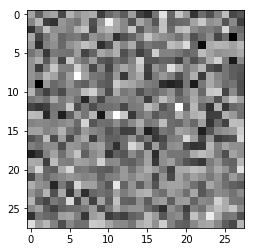

Train Epoch: 71 [Iter: 100]	 Gloss: -0.833040 Dloss: 0.833040
Train Epoch: 71 [Iter: 200]	 Gloss: -0.835685 Dloss: 0.835685
Train Epoch: 71 [Iter: 300]	 Gloss: -0.836285 Dloss: 0.836285
Train Epoch: 72 [Iter: 100]	 Gloss: -0.833829 Dloss: 0.833829
Train Epoch: 72 [Iter: 200]	 Gloss: -0.831544 Dloss: 0.831544
Train Epoch: 72 [Iter: 300]	 Gloss: -0.836104 Dloss: 0.836104
Train Epoch: 73 [Iter: 100]	 Gloss: -0.830903 Dloss: 0.830903
Train Epoch: 73 [Iter: 200]	 Gloss: -0.831301 Dloss: 0.831301
Train Epoch: 73 [Iter: 300]	 Gloss: -0.832976 Dloss: 0.832976
Train Epoch: 74 [Iter: 100]	 Gloss: -0.830673 Dloss: 0.830673
Train Epoch: 74 [Iter: 200]	 Gloss: -0.834970 Dloss: 0.834970
Train Epoch: 74 [Iter: 300]	 Gloss: -0.827331 Dloss: 0.827331
Train Epoch: 75 [Iter: 100]	 Gloss: -0.834905 Dloss: 0.834905
Train Epoch: 75 [Iter: 200]	 Gloss: -0.840474 Dloss: 0.840474
Train Epoch: 75 [Iter: 300]	 Gloss: -0.838268 Dloss: 0.838268
Train Epoch: 76 [Iter: 100]	 Gloss: -0.832155 Dloss: 0.832155
Train Ep

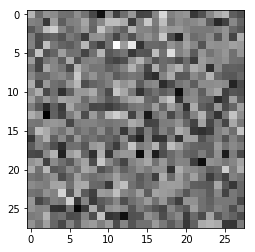

Train Epoch: 81 [Iter: 100]	 Gloss: -0.836958 Dloss: 0.836958
Train Epoch: 81 [Iter: 200]	 Gloss: -0.841039 Dloss: 0.841039
Train Epoch: 81 [Iter: 300]	 Gloss: -0.831179 Dloss: 0.831179
Train Epoch: 82 [Iter: 100]	 Gloss: -0.842517 Dloss: 0.842517
Train Epoch: 82 [Iter: 200]	 Gloss: -0.832510 Dloss: 0.832510
Train Epoch: 82 [Iter: 300]	 Gloss: -0.836013 Dloss: 0.836013
Train Epoch: 83 [Iter: 100]	 Gloss: -0.835855 Dloss: 0.835855
Train Epoch: 83 [Iter: 200]	 Gloss: -0.838584 Dloss: 0.838584
Train Epoch: 83 [Iter: 300]	 Gloss: -0.832461 Dloss: 0.832461
Train Epoch: 84 [Iter: 100]	 Gloss: -0.832783 Dloss: 0.832783
Train Epoch: 84 [Iter: 200]	 Gloss: -0.836213 Dloss: 0.836213
Train Epoch: 84 [Iter: 300]	 Gloss: -0.832453 Dloss: 0.832453
Train Epoch: 85 [Iter: 100]	 Gloss: -0.835969 Dloss: 0.835969
Train Epoch: 85 [Iter: 200]	 Gloss: -0.830439 Dloss: 0.830439
Train Epoch: 85 [Iter: 300]	 Gloss: -0.845427 Dloss: 0.845427
Train Epoch: 86 [Iter: 100]	 Gloss: -0.833742 Dloss: 0.833742
Train Ep

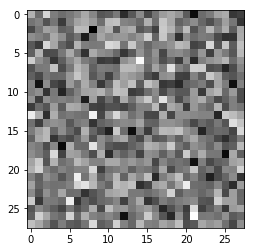

Train Epoch: 91 [Iter: 100]	 Gloss: -0.835635 Dloss: 0.835635
Train Epoch: 91 [Iter: 200]	 Gloss: -0.830131 Dloss: 0.830131
Train Epoch: 91 [Iter: 300]	 Gloss: -0.836095 Dloss: 0.836095
Train Epoch: 92 [Iter: 100]	 Gloss: -0.833605 Dloss: 0.833605
Train Epoch: 92 [Iter: 200]	 Gloss: -0.836369 Dloss: 0.836369
Train Epoch: 92 [Iter: 300]	 Gloss: -0.835905 Dloss: 0.835905
Train Epoch: 93 [Iter: 100]	 Gloss: -0.827221 Dloss: 0.827221
Train Epoch: 93 [Iter: 200]	 Gloss: -0.834776 Dloss: 0.834776
Train Epoch: 93 [Iter: 300]	 Gloss: -0.835054 Dloss: 0.835054
Train Epoch: 94 [Iter: 100]	 Gloss: -0.837781 Dloss: 0.837781
Train Epoch: 94 [Iter: 200]	 Gloss: -0.829077 Dloss: 0.829077
Train Epoch: 94 [Iter: 300]	 Gloss: -0.838650 Dloss: 0.838650
Train Epoch: 95 [Iter: 100]	 Gloss: -0.833136 Dloss: 0.833136
Train Epoch: 95 [Iter: 200]	 Gloss: -0.841479 Dloss: 0.841479
Train Epoch: 95 [Iter: 300]	 Gloss: -0.837687 Dloss: 0.837687
Train Epoch: 96 [Iter: 100]	 Gloss: -0.837901 Dloss: 0.837901
Train Ep

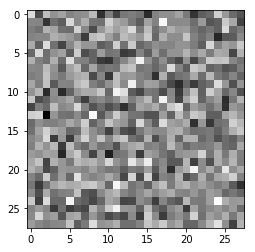

In [122]:
torch.cuda.set_device(1)
_ = train(g_model, d_model, train_loader)

In [54]:
torch.randn(10000).std()

tensor(1.0018)

In [68]:
torch.ones(1)

tensor([1.])